# Tiền xử lý dữ liệu

In [ ]:
!pip install nltk

In [ ]:
import pandas as pd
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
train_df = pd.read_csv('BBC News Train.csv')
test_df = pd.read_csv('BBC News Test.csv')

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"[^a-z\s]", '', text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [ ]:
train_df['Text'] = train_df['Text'].apply(clean_text)
test_df['Text'] = test_df['Text'].apply(clean_text)

In [ ]:
train_df

,ArticleId,Text,Category
0,1833,worldcom exboss launch defence lawyer defendin...,business
1,154,german business confidence slide german busine...,business
2,1101,bbc poll indicates economic gloom citizen majo...,business
3,1976,lifestyle governs mobile choice faster better ...,tech
4,917,enron boss payout eighteen former enron direct...,business
...,...,...,...
1485,857,double eviction big brother model caprice holb...,entertainment
1486,325,dj double act revamp chart show dj duo jk joel...,entertainment
1487,1590,weak dollar hit reuters revenue medium group r...,business
1488,1587,apple ipod family expands market apple expande...,tech


In [ ]:
test_df

,ArticleId,Text
0,1018,qpr keeper day head preston queen park ranger ...
1,1319,software watching work software monitor every ...
2,1138,arcy injury add ireland woe gordon arcy ruled ...
3,459,india reliance family feud heat ongoing public...
4,1020,boro suffer morrison injury blow middlesbrough...
...,...,...
730,1923,eu probe alitalia state aid european commissio...
731,373,u play grammy award show irish rock band u pla...
732,1704,sport betting rule spotlight group mp peer cal...
733,206,alfa romeo get gm engine fiat stop making sixc...


# Khám phá dữ liệu

Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64


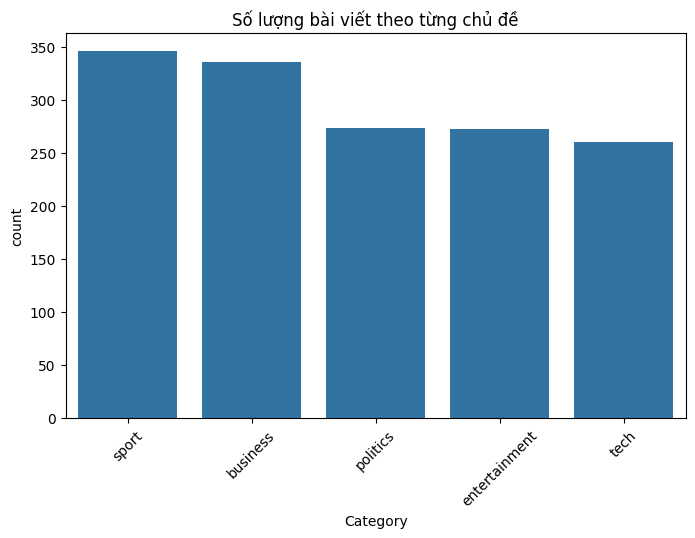

In [ ]:
# Đếm số lượng bài viết theo từng chủ đề
print(train_df['Category'].value_counts())
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.countplot(data=train_df, x='Category', order=train_df['Category'].value_counts().index)
plt.title('Số lượng bài viết theo từng chủ đề')
plt.xticks(rotation=45)
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def extract_top_tfidf_keywords(df, category_column, text_column, top_n=10):
    categories = df[category_column].unique()
    for cat in categories:
        texts = df[df[category_column] == cat][text_column]
        vectorizer = TfidfVectorizer(
            max_features=1000,
            token_pattern=r'\b[a-z]{3,}\b'
        )

        # Tạo ma trận TF-IDF
        tfidf_matrix = vectorizer.fit_transform(texts)

        # Tính điểm TF-IDF trung bình cho mỗi từ
        avg_tfidf = tfidf_matrix.mean(axis=0).A1
        feature_names = vectorizer.get_feature_names_out()

        # Sắp xếp và lấy top N từ
        word_scores = [(feature_names[i], avg_tfidf[i]) for i in range(len(feature_names))]
        top_words = sorted(word_scores, key=lambda x: x[1], reverse=True)[:top_n]

        # In kết quả
        print(f"\nTừ khóa đặc trưng cho chủ đề: {cat}")
        for word, score in top_words:
            print(f"  {word} ({round(score, 3)})")

extract_top_tfidf_keywords(train_df, 'Category', 'Text', top_n=10)


Từ khóa đặc trưng cho chủ đề: business
  said (0.064)
  year (0.042)
  firm (0.037)
  company (0.036)
  sale (0.034)
  bank (0.031)
  market (0.031)
  growth (0.031)
  share (0.03)
  economy (0.03)

Từ khóa đặc trưng cho chủ đề: tech
  said (0.065)
  mobile (0.049)
  game (0.048)
  phone (0.048)
  people (0.046)
  service (0.037)
  technology (0.034)
  software (0.031)
  user (0.03)
  year (0.03)

Từ khóa đặc trưng cho chủ đề: politics
  said (0.091)
  labour (0.053)
  election (0.05)
  would (0.05)
  blair (0.047)
  party (0.046)
  brown (0.041)
  tory (0.038)
  government (0.038)
  tax (0.038)

Từ khóa đặc trưng cho chủ đề: sport
  said (0.047)
  game (0.039)
  england (0.038)
  win (0.03)
  player (0.03)
  world (0.029)
  first (0.029)
  year (0.029)
  match (0.027)
  last (0.027)

Từ khóa đặc trưng cho chủ đề: entertainment
  film (0.082)
  said (0.054)
  best (0.051)
  award (0.045)
  year (0.039)
  show (0.038)
  music (0.034)
  band (0.031)
  star (0.03)
  also (0.03)


# Chuẩn bị dữ liệu

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(train_df['Category'])
print(le.classes_)

['business' 'entertainment' 'politics' 'sport' 'tech']


In [ ]:
# Chia tập train thành train và validation
X_train_text, X_val_text, y_train_split, y_val_split = train_test_split(train_df['Text'], y_train, test_size=0.2, random_state=42, stratify=y_train)


# TF-IDF + SVM

In [ ]:
# Khởi tạo TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_val_tfidf = vectorizer.transform(X_val_text)
X_test_tfidf = vectorizer.transform(test_df['Text'])

In [ ]:
# Initialize and train the LinearSVC model
model_svm_tfidf = LinearSVC(max_iter=1000)
model_svm_tfidf.fit(X_train_tfidf, y_train_split)

LinearSVC()

In [ ]:
# Đánh giá trên tập validation
y_val_pred = model_svm_tfidf.predict(X_val_tfidf)
acc = accuracy_score(y_val_split, y_val_pred)
f1_macro = f1_score(y_val_split, y_val_pred, average="macro")
f1_micro = f1_score(y_val_split, y_val_pred, average="micro")
f1_weighted = f1_score(y_val_split, y_val_pred, average="weighted")

print(f"Accuracy: {acc:.4f}")
print(f"F1-score (Macro): {f1_macro:.4f}")
print(f"F1-score (Micro): {f1_micro:.4f}")
print(f"F1-score (Weighted): {f1_weighted:.4f}")

Accuracy: 0.9799
F1-score (Macro): 0.9787
F1-score (Micro): 0.9799
F1-score (Weighted): 0.9798


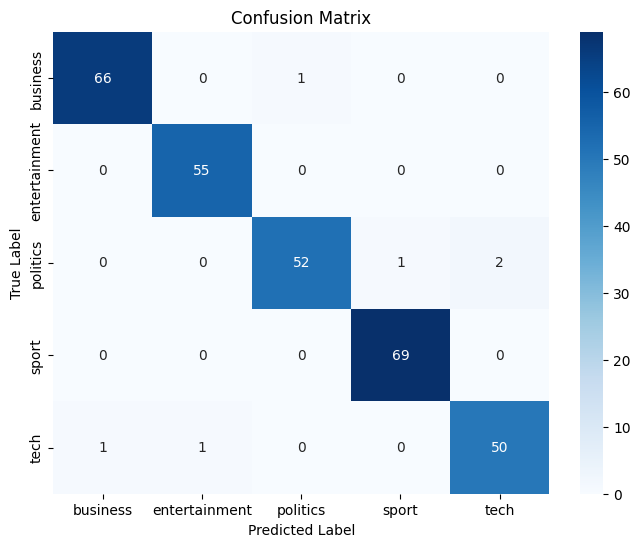

In [ ]:
# Vẽ ma trận nhầm lẫn
cm = confusion_matrix(y_val_split, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Huấn luyện lại trên toàn bộ tập train
model_svm_tfidf.fit(vectorizer.fit_transform(train_df['Text']), y_train)

# Dự đoán trên tập test
y_test_pred_tfidf = model_svm_tfidf.predict(X_test_tfidf)
predicted_labels_tfidf = le.inverse_transform(y_test_pred_tfidf)

submission_df = pd.DataFrame({
    'ArticleId': test_df['ArticleId'],
    'Category': predicted_labels_tfidf
})
submission_df

,ArticleId,Category
0,1018,business
1,1319,business
2,1138,sport
3,459,politics
4,1020,tech
...,...,...
730,1923,business
731,373,business
732,1704,entertainment
733,206,sport


# BERT


In [ ]:
!pip install transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 33.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [ ]:
# Định nghĩa lớp Dataset cho BERT
class BBCNewsDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item


In [ ]:
# Tải tokenizer và mô hình BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(le.classes_)
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tạo Dataset và DataLoader
train_dataset = BBCNewsDataset(X_train_text, y_train_split, tokenizer)
val_dataset = BBCNewsDataset(X_val_text, y_val_split, tokenizer)
test_dataset = BBCNewsDataset(test_df['Text'].values, tokenizer=tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Thiết lập thiết bị (GPU nếu có)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Thiết lập optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

In [ ]:
def train_model(model, train_loader, optimizer, device, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            progress_bar.set_postfix({'loss': loss.item()})
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")

In [ ]:
def evaluate_model(model, val_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    # Tính các chỉ số
    acc = accuracy_score(true_labels, predictions)
    f1_macro = f1_score(true_labels, predictions, average='macro')
    f1_micro = f1_score(true_labels, predictions, average='micro')
    f1_weighted = f1_score(true_labels, predictions, average='weighted')
    cm = confusion_matrix(true_labels, predictions)

    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score (Macro): {f1_macro:.4f}")
    print(f"F1-score (Micro): {f1_micro:.4f}")
    print(f"F1-score (Weighted): {f1_weighted:.4f}")

    # Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    return predictions, true_labels
train_model(model, train_loader, optimizer, device, epochs=3)

Epoch 1: 100%|██████████| 75/75 [02:01<00:00,  1.62s/it, loss=0.0152]


Epoch 1, Average Loss: 0.0283


Epoch 2: 100%|██████████| 75/75 [02:00<00:00,  1.60s/it, loss=0.00847]


Epoch 2, Average Loss: 0.0162


Epoch 3: 100%|██████████| 75/75 [01:59<00:00,  1.60s/it, loss=0.00712]

Epoch 3, Average Loss: 0.0133



Đánh giá trên tập validation:


Evaluating: 100%|██████████| 19/19 [00:10<00:00,  1.80it/s]


Accuracy: 0.9732
F1-score (Macro): 0.9717
F1-score (Micro): 0.9732
F1-score (Weighted): 0.9730


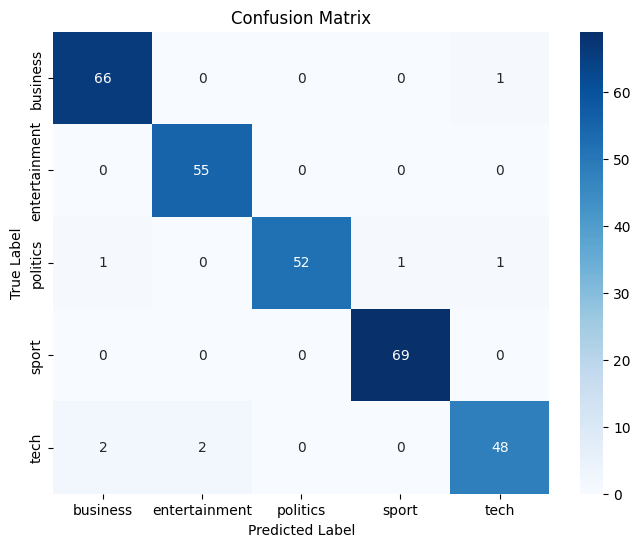

Predicting on test: 100%|██████████| 46/46 [00:27<00:00,  1.66it/s]


,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
...,...,...
730,1923,business
731,373,entertainment
732,1704,politics
733,206,business


In [ ]:
# Đánh giá trên tập validation
print("\nĐánh giá trên tập validation:")
val_predictions, val_true_labels = evaluate_model(model, val_loader, device)

# Dự đoán trên tập test
def predict_test(model, test_loader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Predicting on test"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
    return predictions

# Dự đoán và tạo file nộp bài
test_predictions = predict_test(model, test_loader, device)
predicted_labels = le.inverse_transform(test_predictions)

submission_df = pd.DataFrame({
    'ArticleId': test_df['ArticleId'],
    'Category': predicted_labels
})
submission_df
#submission_df.to_csv('submission.csv', index=False)